In [23]:
#import all necessary liberty

import random

%matplotlib inline
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

import pandas as pd


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras import optimizers
#from sklearn.utils import shuffle
import csv

#spliting dataset into traning set and test set
from sklearn.model_selection import train_test_split
#missing value handle
from sklearn.preprocessing import Imputer
#To shuffle the data set
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

import itertools

from scipy.stats import zscore

import os


In [2]:
os.environ['PYTHONHASHSEED'] = '0'

tf.set_random_seed(23)
np.random.seed(37)
random.seed(21)

In [44]:
class Neural_Network:
    data_frame = []
    df_after_shuffle = []
    data_set = []
    len_of_data_frame = []
    actual_x = []
    actual_y = []
    test_x = []
    test_y = []
    train_x = []
    train_y = []
    predicted_result = []
    rounded_predicted_result = []
    kfold_validation_score_store = []
    input_shape = 0
    learning_rate = .001
    best_score = 0.0
    score = []
    cm = []
    
    def __init__(self,file_name):
        self.data_frame = pd.read_csv(file_name, sep='\t')
        self.len_of_data_frame = len(self.data_frame)
        self.input_shape = len(self.data_frame.columns)-2
        
        self.shuffle_the_data()
        
        
    def shuffle_the_data(self):
        #shuffle the data set
        #np.random.seed(40)
        self.df_after_shuffle = self.data_frame.reindex(np.random.permutation(self.data_frame.index))
        self.df_after_shuffle.reset_index(inplace=True,drop=True)
        
        self.x_data_y_data_create()
    
    def x_data_y_data_create(self):
        self.data_set = self.df_after_shuffle.values
        self.actual_x = self.data_set[:,:self.input_shape]
        self.actual_y = self.data_set[:,self.input_shape+1:]
        
    
    def cross_validation_model_training(self,n_Of_fold=10):
        kf = KFold(n_Of_fold)
        fold = 0
        #self.best_score = self.score
        terget_names = ["NO","YES"]
        
        for train,test in kf.split(self.actual_x):
            fold += 1
            print("fold #{}".format(fold))
            self.train_x = self.actual_x[train]
            self.train_y = self.actual_y[train]
            self.test_x = self.actual_x[test]
            self.test_y = self.actual_y[test]
            
            model = Sequential([
            Dense(8,input_shape=(self.input_shape,),activation="relu"),
            Dense(7,activation="relu"),
            Dense(6,activation="relu"),
            Dense(2,activation="softmax")
            ])

            model.compile(
                Adam(lr=self.learning_rate),loss='sparse_categorical_crossentropy',metrics=['accuracy']
            )
            
            
            model.fit(self.train_x, self.train_y,
                      validation_data = (self.test_x,self.test_y),
                      batch_size=10,epochs=200,shuffle=True,verbose=0)
            
            #model.save("heart_attack_risk_prediction_fold_no_"+str(fold)+"_with_cross_validation.h5")
            
            rounded_predections = model.predict_classes(self.test_x,batch_size=10,verbose=0)
            self.rounded_predicted_result = rounded_predections
            #pred = model.predict(self.test_x)
            pred_class = model.predict_classes(self.test_x)
            self.score = model.evaluate(self.test_x, self.test_y)
            
            if(self.best_score<self.score[1]):
                self.best_score = self.score[1]
                self.model = model
            
            self.kfold_validation_score_store.append(self.score)
            
            print("\nFold {0} score : {1}\n Score: {2}".format(fold,self.score,self.best_score))
            
            #print("\n\n")
            
            self.confussion_matrix_generator()
            self.ROC_curve_generator()
            
            print(classification_report(pred_class,self.test_y,target_names=terget_names))
            
            self.performance()
            
            print("\n\n\n")
            #break
        else:
            self.save_model("cross_validation")
        
    def create_model(self):
        model = Sequential([
        Dense(8,input_shape=(self.input_shape,),activation="relu"),
        Dense(7,activation="relu"),
        Dense(2,activation="softmax")
        ])

        model.compile(loss= 'sparse_categorical_crossentropy',
                      optimizer=optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
                      metrics=['accuracy'])
        
        self.model = model
    
    def split_data(self):
        # split into train and test sets
        train_size = int(len(self.data_set) * 0.80)
        test_size = len(self.data_set) - train_size   
        train, test = self.data_set[0:train_size,:], self.data_set[train_size:len(self.data_set),:]
        
        self.train_x = train[:,:self.input_shape]
        self.train_y = train[:,self.input_shape+1:]

        self.test_x = test[:,:self.input_shape]
        self.test_y = test[:,self.input_shape+1:]

        print(len(train), len(test))
    
    def percent_split_model_traning(self):
        self.shuffle_the_data()
        self.split_data()
        self.model.fit(self.train_x, self.train_y,
                  validation_data = (self.test_x,self.test_y),
                  batch_size=20,epochs=500,shuffle=True,verbose=2)
        #self.save_model("percent_split")
        
        
        
    def model_performance(self,test_x=[],test_y=[]):
        if(test_x==[] and test_y==[]):
            test_x=self.test_x
            test_y=self.test_y
        else:
            self.test_x=test_x
            self.test_y=test_y
        
        rounded_predections = self.model.predict_classes(test_x,batch_size=10,verbose=0)
        self.rounded_predicted_result = rounded_predections
        #pred = model.predict(self.test_x)
        pred_class = rounded_predections
        self.score = self.model.evaluate(test_x, test_y)
        
        self.confussion_matrix_generator()
        self.ROC_curve_generator()
        
        terget_names = ["NO","YES"]
        print(classification_report(pred_class,test_y,target_names=terget_names))

        self.performance()
        
            
    def ROC_curve_generator(self):
        #ROC curve

        # calculate the fpr and tpr for all thresholds of the classification
        probs = self.model.predict_proba(self.test_x)
        preds = probs[:,1]
        fpr, tpr, threshold = metrics.roc_curve(self.test_y, preds)
        roc_auc = metrics.auc(fpr, tpr)

        # method I: plt
        import matplotlib.pyplot as plt
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    def confussion_matrix_generator(self):
        #rounded_predections = self.model.predict_classes(self.test_x,batch_size=10,verbose=0)
        cm = confusion_matrix(self.test_y,self.rounded_predicted_result)
        self.cm = cm
        cm_plot_labels = ['no side effects', 'have side effects']
        print(cm)
        #self.plot_confusion_matrix(cm,cm_plot_labels,title='Confussion Matrix')

        
    def plot_confusion_matrix(self,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        #print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
    def performance(self):
        TN = self.cm[0][0]
        FP = self.cm[0][1]
        FN = self.cm[1][0]
        TP = self.cm[1][1]
        
        n =TN+FP+FN+TP
        print("numer of total test sample: ",n)
        
        print("Model Score: ", self.score)
        
        accuracy = (TP+TN)/n
        print("accuracy: ",accuracy)

        missclassafication_rate = 1-accuracy
        print("missclassafication_rate: ",missclassafication_rate)

        sensitivity = TP/(TP+FN)
        print("Sensitivity/Recall: ",sensitivity)

        spasificity = TN/(TN+FP)
        print("Spacificity: ",spasificity)

        precition = TP/(FP+TP)
        print("Precition: ",precition)

        prevalence = (FN+TP)/n
        print("prevalence: ",prevalence)

        PPV = TP/(TP+FP)
        print("Positive Predicted Value: ",PPV)

        NPV = TN/(TN+FN)
        print("Negative Predicted Value: ",NPV)

        beta = 0.5
        f_score = 1/(beta*(1/precition)+(1-beta)*(1/sensitivity))
        print("F Score: ",f_score)
        
    def save_model(self,string):
        self.model.save("heart_attack_risk_prediction_"+string+".h5")
    
    def user_data_predict(self,data):
        data = np.expand_dims(data, axis=0)
        predections = self.model.predict_classes(data,batch_size=10,verbose=0)
        return predections[0]

In [39]:
nn = Neural_Network('data_834.tab')

In [40]:
nn.data_frame.head(3)

,50.0,1.0,0.0,1.0.1,0.0.1,0.0.2,0.0.3,0.0.4,1.0.2,0.0.5,0.0.6,0.0.7,0.0.8,1.0.3,1.0.4
0,60.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,45.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
2,38.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [41]:
for i in nn.data_set:
    print(i)

[60.  1.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.]
[70.  2.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.]
[72.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.]
[63.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.]
[69.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.  0.]
[75.  2.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
[82.  1.  2.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
[60.  2.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[48.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[38.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.]
[59.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]
[65.  2.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.]
[25.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
[50.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.]
[48.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
[33.  2.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.]
[84.  1.

[70.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.]
[38.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
[42.  1.  0.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.]
[48.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[65.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  1.]
[52.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
[59.  1.  2.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.]
[56.  1.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.]
[35.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[55.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.]
[53.32490975  2.          0.          0.          0.          0.
  0.          1.          1.          0.          0.          1.
  0.          0.          0.        ]
[75.  2.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]
[52.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.]
[65.  1.  2.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.]
[45.  1.  0.  1.  0.  0.  

In [42]:
nn.len_of_data_frame

834

In [7]:
nn.shuffle_the_data()

In [8]:
nn.create_model()

In [29]:
#percent split
nn = Neural_Network('data_834.tab')
nn.shuffle_the_data()
nn.create_model()
for i in range(5):
    #print(nn.data_frame.head(5))
    print("----------------------------------------------",i,"-----------------------------------------")
    nn.percent_split_model_traning()
    print("\n\n")

667 167
Train on 667 samples, validate on 167 samples
Epoch 1/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 2/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 3/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 4/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 5/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 6/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 7/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 8/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 9/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 10/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 11/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 12/500
 - 0s -

Epoch 97/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 98/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 99/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 100/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 101/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 102/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 103/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 104/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 105/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 106/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 107/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 108/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_lo

Epoch 193/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 194/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 195/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 196/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 197/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 198/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 199/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 200/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 201/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 202/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 203/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 204/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val

Epoch 289/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 290/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 291/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 292/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 293/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 294/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 295/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 296/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 297/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 298/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 299/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 300/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val

Epoch 385/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 386/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 387/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 388/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 389/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 390/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 391/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 392/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 393/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 394/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 395/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 396/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val

Epoch 481/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 482/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 483/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 484/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 485/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 486/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 487/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 488/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 489/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 490/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 491/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val_loss: 9.7481 - val_acc: 0.3952
Epoch 492/500
 - 0s - loss: 9.6902 - acc: 0.3988 - val

Epoch 77/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 78/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 79/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 80/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 81/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 82/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 83/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 84/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 85/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 86/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 87/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 88/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.265

Epoch 173/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 174/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 175/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 176/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 177/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 178/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 179/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 180/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 181/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 182/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 183/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 184/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val

Epoch 269/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 270/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 271/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 272/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 273/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 274/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 275/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 276/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 277/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 278/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 279/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 280/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val

Epoch 365/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 366/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 367/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 368/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 369/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 370/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 371/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 372/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 373/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 374/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 375/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 376/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val

Epoch 461/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 462/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 463/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 464/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 465/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 466/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 467/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 468/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 469/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 470/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 471/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 472/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val

Epoch 57/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 58/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 59/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 60/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 61/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 62/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 63/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 64/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 65/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 66/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 67/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 68/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.941

Epoch 153/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 154/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 155/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 156/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 157/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 158/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 159/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 160/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 161/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 162/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 163/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 164/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val

Epoch 249/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 250/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 251/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 252/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 253/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 254/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 255/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 256/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 257/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 258/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 259/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 260/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val

Epoch 345/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 346/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 347/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 348/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 349/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 350/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 351/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 352/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 353/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 354/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 355/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 356/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val

Epoch 441/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 442/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 443/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 444/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 445/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 446/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 447/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 448/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 449/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 450/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 451/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val_loss: 9.9411 - val_acc: 0.3832
Epoch 452/500
 - 0s - loss: 9.6419 - acc: 0.4018 - val

 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 37/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 38/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 39/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 40/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 41/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 42/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 43/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 44/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 45/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 46/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 47/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 

 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 133/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 134/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 135/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 136/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 137/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 138/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 139/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 140/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 141/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 142/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 143/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 

Epoch 228/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 229/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 230/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 231/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 232/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 233/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 234/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 235/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 236/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 237/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 238/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 239/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val

Epoch 324/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 325/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 326/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 327/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 328/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 329/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 330/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 331/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 332/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 333/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 334/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 335/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val

Epoch 420/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 421/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 422/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 423/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 424/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 425/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 426/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 427/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 428/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 429/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 430/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val_loss: 9.2655 - val_acc: 0.4251
Epoch 431/500
 - 0s - loss: 9.8110 - acc: 0.3913 - val

Epoch 15/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 16/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 17/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 18/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 19/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 20/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 21/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 22/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 23/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 24/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 25/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 26/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.458

Epoch 112/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 113/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 114/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 115/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 116/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 117/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 118/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 119/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 120/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 121/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 122/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 123/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val

Epoch 208/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 209/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 210/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 211/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 212/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 213/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 214/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 215/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 216/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 217/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 218/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 219/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val

Epoch 304/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 305/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 306/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 307/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 308/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 309/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 310/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 311/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 312/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 313/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 314/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 315/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val

Epoch 400/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 401/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 402/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 403/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 404/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 405/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 406/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 407/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 408/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 409/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 410/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 411/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val

Epoch 496/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 497/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 498/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 499/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132
Epoch 500/500
 - 0s - loss: 9.7627 - acc: 0.3943 - val_loss: 9.4585 - val_acc: 0.4132



667 167
Train on 667 samples, validate on 167 samples
Epoch 1/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 2/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 3/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 4/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 5/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 6/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 7/5

Epoch 92/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 93/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 94/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 95/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 96/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 97/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 98/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 99/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 100/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 101/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 102/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 103/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9

Epoch 188/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 189/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 190/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 191/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 192/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 193/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 194/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 195/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 196/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 197/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 198/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 199/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val

Epoch 284/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 285/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 286/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 287/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 288/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 289/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 290/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 291/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 292/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 293/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 294/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 295/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val

Epoch 380/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 381/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 382/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 383/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 384/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 385/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 386/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 387/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 388/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 389/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 390/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 391/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val

Epoch 476/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 477/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 478/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 479/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 480/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 481/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 482/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 483/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 484/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 485/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 486/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val_loss: 9.5550 - val_acc: 0.4072
Epoch 487/500
 - 0s - loss: 9.7385 - acc: 0.3958 - val

Epoch 72/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 73/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 74/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 75/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 76/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 77/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 78/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 79/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 80/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 81/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 82/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 83/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.844

Epoch 168/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 169/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 170/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 171/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 172/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 173/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 174/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 175/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 176/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 177/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 178/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 179/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val

Epoch 264/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 265/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 266/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 267/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 268/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 269/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 270/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 271/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 272/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 273/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 274/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 275/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val

Epoch 360/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 361/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 362/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 363/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 364/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 365/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 366/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 367/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 368/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 369/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 370/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 371/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val

Epoch 456/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 457/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 458/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 459/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 460/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 461/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 462/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 463/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 464/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 465/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 466/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 467/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val

Epoch 51/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 52/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 53/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 54/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 55/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 56/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 57/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 58/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 59/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 60/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 61/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 62/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_

Epoch 146/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 147/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 148/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 149/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 150/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 151/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 152/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 153/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 154/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 155/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 156/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 157/500
 - 0s - loss: 9.6177 - acc: 0

Epoch 241/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 242/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 243/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 244/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 245/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 246/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 247/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 248/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 249/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 250/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 251/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 252/500
 - 0s - loss: 9.6177 - acc: 0

Epoch 336/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 337/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 338/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 339/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 340/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 341/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 342/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 343/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 344/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 345/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 346/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 347/500
 - 0s - loss: 9.6177 - acc: 0

Epoch 431/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 432/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 433/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 434/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 435/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 436/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 437/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 438/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 439/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 440/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 441/500
 - 0s - loss: 9.6177 - acc: 0.4033 - val_loss: 10.0376 - val_acc: 0.3772
Epoch 442/500
 - 0s - loss: 9.6177 - acc: 0

Epoch 25/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 26/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 27/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 28/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 29/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 30/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 31/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 32/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 33/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 34/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 35/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 36/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_

 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 121/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 122/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 123/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 124/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 125/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 126/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 127/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 128/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 129/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 130/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 131/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_lo

Epoch 215/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 216/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 217/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 218/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 219/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 220/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 221/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 222/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 223/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 224/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 225/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 226/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 310/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 311/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 312/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 313/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 314/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 315/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 316/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 317/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 318/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 319/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 320/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 321/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 405/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 406/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 407/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 408/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 409/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 410/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 411/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 412/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 413/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 414/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 415/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 416/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 500/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593



667 167
Train on 667 samples, validate on 167 samples
Epoch 1/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 2/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 3/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 4/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 5/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 6/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 7/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 8/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 9/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 10/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch

Epoch 95/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 96/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 97/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 98/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 99/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 100/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 101/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 102/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 103/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 104/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 105/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 106/500
 - 0s - loss: 9.5935 - acc: 0.4048

Epoch 190/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 191/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 192/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 193/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 194/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 195/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 196/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 197/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 198/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 199/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 200/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 201/500
 - 0s - loss: 9.5935 - acc: 0

Epoch 285/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 286/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 287/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 288/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 289/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 290/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 291/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 292/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 293/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 294/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 295/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 296/500
 - 0s - loss: 9.5935 - acc: 0

Epoch 380/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 381/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 382/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 383/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 384/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 385/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 386/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 387/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 388/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 389/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 390/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 391/500
 - 0s - loss: 9.5935 - acc: 0

Epoch 475/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 476/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 477/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 478/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 479/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 480/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 481/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 482/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 483/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 484/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 485/500
 - 0s - loss: 9.5935 - acc: 0.4048 - val_loss: 10.1341 - val_acc: 0.3713
Epoch 486/500
 - 0s - loss: 9.5935 - acc: 0

Epoch 70/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 71/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 72/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 73/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 74/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 75/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 76/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 77/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 78/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 79/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 80/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 81/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val

Epoch 165/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 166/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 167/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 168/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 169/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 170/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 171/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 172/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 173/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 174/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 175/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 176/500
 - 0s - loss: 10.1010 - acc: 

Epoch 260/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 261/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 262/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 263/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 264/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 265/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 266/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 267/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 268/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 269/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 270/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 271/500
 - 0s - loss: 10.1010 - acc: 

Epoch 355/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 356/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 357/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 358/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 359/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 360/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 361/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 362/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 363/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 364/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 365/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 366/500
 - 0s - loss: 10.1010 - acc: 

Epoch 450/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 451/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 452/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 453/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 454/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 455/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 456/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 457/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 458/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 459/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 460/500
 - 0s - loss: 10.1010 - acc: 0.3733 - val_loss: 8.1073 - val_acc: 0.4970
Epoch 461/500
 - 0s - loss: 10.1010 - acc: 

Epoch 45/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 46/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 47/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 48/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 49/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 50/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 51/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 52/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 53/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 54/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 55/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 56/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.844

Epoch 141/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 142/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 143/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 144/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 145/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 146/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 147/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 148/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 149/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 150/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 151/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 152/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val

Epoch 237/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 238/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 239/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 240/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 241/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 242/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 243/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 244/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 245/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 246/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 247/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 248/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val

Epoch 333/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 334/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 335/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 336/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 337/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 338/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 339/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 340/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 341/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 342/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 343/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 344/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val

Epoch 429/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 430/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 431/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 432/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 433/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 434/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 435/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 436/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 437/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 438/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 439/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val_loss: 9.8446 - val_acc: 0.3892
Epoch 440/500
 - 0s - loss: 9.6660 - acc: 0.4003 - val

Epoch 24/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 25/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 26/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 27/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 28/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 29/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 30/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 31/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 32/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 33/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 34/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 35/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_

 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 120/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 121/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 122/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 123/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 124/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 125/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 126/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 127/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 128/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 129/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 130/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_lo

Epoch 214/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 215/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 216/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 217/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 218/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 219/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 220/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 221/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 222/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 223/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 224/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 225/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 309/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 310/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 311/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 312/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 313/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 314/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 315/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 316/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 317/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 318/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 319/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 320/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 404/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 405/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 406/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 407/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 408/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 409/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 410/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 411/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 412/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 413/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 414/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 415/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 499/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 500/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593



667 167
Train on 667 samples, validate on 167 samples
Epoch 1/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 2/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 3/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 4/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 5/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 6/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 7/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 8/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 9/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoc

Epoch 94/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 95/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 96/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 97/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 98/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 99/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 100/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 101/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 102/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 103/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 104/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 105/500
 - 0s - loss: 9.5452 - acc: 0.4078 

Epoch 189/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 190/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 191/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 192/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 193/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 194/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 195/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 196/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 197/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 198/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 199/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 200/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 284/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 285/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 286/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 287/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 288/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 289/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 290/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 291/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 292/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 293/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 294/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 295/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 379/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 380/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 381/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 382/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 383/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 384/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 385/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 386/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 387/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 388/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 389/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 390/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 474/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 475/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 476/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 477/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 478/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 479/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 480/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 481/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 482/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 483/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 484/500
 - 0s - loss: 9.5452 - acc: 0.4078 - val_loss: 10.3272 - val_acc: 0.3593
Epoch 485/500
 - 0s - loss: 9.5452 - acc: 0

Epoch 70/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 71/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 72/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 73/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 74/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 75/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 76/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 77/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 78/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 79/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 80/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 81/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.589

Epoch 166/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 167/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 168/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 169/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 170/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 171/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 172/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 173/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 174/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 175/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 176/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 177/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val

Epoch 262/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 263/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 264/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 265/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 266/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 267/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 268/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 269/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 270/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 271/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 272/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 273/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val

Epoch 358/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 359/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 360/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 361/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 362/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 363/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 364/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 365/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 366/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 367/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 368/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 369/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val

Epoch 454/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 455/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 456/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 457/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 458/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 459/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 460/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 461/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 462/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 463/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 464/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 465/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val

Epoch 50/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 51/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 52/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 53/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 54/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 55/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 56/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 57/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 58/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 59/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 60/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 61/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.589

Epoch 146/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 147/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 148/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 149/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 150/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 151/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 152/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 153/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 154/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 155/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 156/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 157/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val

Epoch 242/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 243/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 244/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 245/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 246/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 247/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 248/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 249/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 250/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 251/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 252/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 253/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val

Epoch 338/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 339/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 340/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 341/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 342/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 343/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 344/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 345/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 346/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 347/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 348/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 349/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val

Epoch 434/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 435/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 436/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 437/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 438/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 439/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 440/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 441/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 442/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 443/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 444/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val_loss: 8.5899 - val_acc: 0.4671
Epoch 445/500
 - 0s - loss: 9.9802 - acc: 0.3808 - val

Epoch 29/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 30/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 31/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 32/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 33/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 34/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 35/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 36/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 37/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 38/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 39/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 40/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_

Epoch 124/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 125/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 126/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 127/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 128/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 129/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 130/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 131/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 132/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 133/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 134/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 135/500
 - 0s - loss: 9.3760 - acc: 0

Epoch 219/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 220/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 221/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 222/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 223/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 224/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 225/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 226/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 227/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 228/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 229/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 230/500
 - 0s - loss: 9.3760 - acc: 0

Epoch 314/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 315/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 316/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 317/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 318/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 319/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 320/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 321/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 322/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 323/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 324/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 325/500
 - 0s - loss: 9.3760 - acc: 0

Epoch 409/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 410/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 411/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 412/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 413/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 414/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 415/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 416/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 417/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 418/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 419/500
 - 0s - loss: 9.3760 - acc: 0.4183 - val_loss: 11.0028 - val_acc: 0.3174
Epoch 420/500
 - 0s - loss: 9.3760 - acc: 0

Epoch 3/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 4/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 5/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 6/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 7/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 8/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 9/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 10/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 11/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 12/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 13/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 14/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val

Epoch 100/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 101/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 102/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 103/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 104/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 105/500
 - 0s - loss: 9.8593 - acc: 0.3883 - val_loss: 9.0725 - val_acc: 0.4371
Epoch 106/500


KeyboardInterrupt: 

167/167 [==============================] - 0s 56us/step
[[73  0]
 [94  0]]


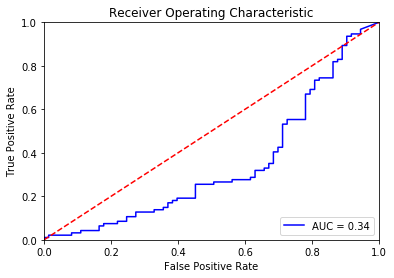

              precision    recall  f1-score   support

          NO       1.00      0.44      0.61       167
         YES       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44       167
   macro avg       0.50      0.22      0.30       167
weighted avg       1.00      0.44      0.61       167

numer of total test sample:  167
Model Score:  [9.072460922652375, 0.4371257490383651]
accuracy:  0.437125748502994
missclassafication_rate:  0.562874251497006
Sensitivity/Recall:  0.0
Spacificity:  1.0
Precition:  nan
prevalence:  0.562874251497006
Positive Predicted Value:  nan
Negative Predicted Value:  0.437125748502994
F Score:  nan


/home/sakib/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:250: RuntimeWarning: invalid value encountered in long_scalars
/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:256: RuntimeWarning: invalid value encountered in long_scalars
/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:263: RuntimeWarning: divide by zero encountered in double_scalars


In [30]:
nn.model_performance()

834/834 [==============================] - 0s 28us/step


/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:141: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


[[332   0]
 [502   0]]


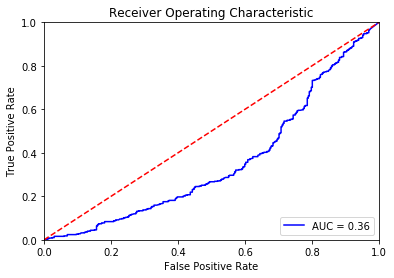

              precision    recall  f1-score   support

          NO       1.00      0.40      0.57       834
         YES       0.00      0.00      0.00         0

   micro avg       0.40      0.40      0.40       834
   macro avg       0.50      0.20      0.28       834
weighted avg       1.00      0.40      0.57       834

numer of total test sample:  834
Model Score:  [9.701779171145505, 0.3980815347721823]
accuracy:  0.3980815347721823
missclassafication_rate:  0.6019184652278178
Sensitivity/Recall:  0.0
Spacificity:  1.0
Precition:  nan
prevalence:  0.6019184652278178
Positive Predicted Value:  nan
Negative Predicted Value:  0.3980815347721823
F Score:  nan


/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:250: RuntimeWarning: invalid value encountered in long_scalars
/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:256: RuntimeWarning: invalid value encountered in long_scalars
/home/sakib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:263: RuntimeWarning: divide by zero encountered in double_scalars


In [31]:
nn.model_performance(nn.actual_x,nn.actual_y)

In [18]:
nn.save_model("percent_split")

In [32]:
nn.user_data_predict([50, 1,0,1,0,1,0,1,1,1,1,0,0])

0

In [36]:
nn.user_data_predict([32, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0])

0

fold #1
84/84 [==============================] - 0s 61us/step

Fold 1 score : [0.5265263773146129, 0.7261904761904762]
 Score: 0.7261904761904762
[[13 13]
 [10 48]]


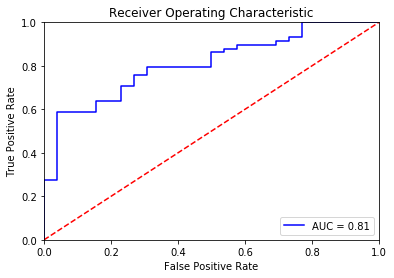

              precision    recall  f1-score   support

          NO       0.50      0.57      0.53        23
         YES       0.83      0.79      0.81        61

   micro avg       0.73      0.73      0.73        84
   macro avg       0.66      0.68      0.67        84
weighted avg       0.74      0.73      0.73        84

numer of total test sample:  84
Model Score:  [0.5265263773146129, 0.7261904761904762]
accuracy:  0.7261904761904762
missclassafication_rate:  0.27380952380952384
Sensitivity/Recall:  0.8275862068965517
Spacificity:  0.5
Precition:  0.7868852459016393
prevalence:  0.6904761904761905
Positive Predicted Value:  0.7868852459016393
Negative Predicted Value:  0.5652173913043478
F Score:  0.8067226890756303
fold #2
84/84 [==============================] - 0s 36us/step

Fold 2 score : [0.6177554300853184, 0.6904761904761905]
 Score: 0.7261904761904762
[[13 20]
 [ 6 45]]


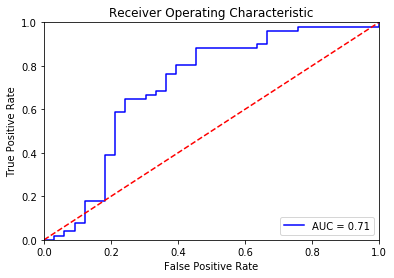

              precision    recall  f1-score   support

          NO       0.39      0.68      0.50        19
         YES       0.88      0.69      0.78        65

   micro avg       0.69      0.69      0.69        84
   macro avg       0.64      0.69      0.64        84
weighted avg       0.77      0.69      0.71        84

numer of total test sample:  84
Model Score:  [0.6177554300853184, 0.6904761904761905]
accuracy:  0.6904761904761905
missclassafication_rate:  0.30952380952380953
Sensitivity/Recall:  0.8823529411764706
Spacificity:  0.3939393939393939
Precition:  0.6923076923076923
prevalence:  0.6071428571428571
Positive Predicted Value:  0.6923076923076923
Negative Predicted Value:  0.6842105263157895
F Score:  0.7758620689655173
fold #3
84/84 [==============================] - 0s 88us/step

Fold 3 score : [0.5748097584361122, 0.7261904790287926]
 Score: 0.7261904790287926
[[25 11]
 [12 36]]


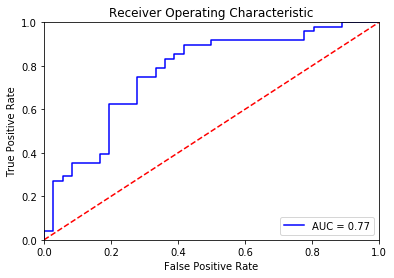

              precision    recall  f1-score   support

          NO       0.69      0.68      0.68        37
         YES       0.75      0.77      0.76        47

   micro avg       0.73      0.73      0.73        84
   macro avg       0.72      0.72      0.72        84
weighted avg       0.73      0.73      0.73        84

numer of total test sample:  84
Model Score:  [0.5748097584361122, 0.7261904790287926]
accuracy:  0.7261904761904762
missclassafication_rate:  0.27380952380952384
Sensitivity/Recall:  0.75
Spacificity:  0.6944444444444444
Precition:  0.7659574468085106
prevalence:  0.5714285714285714
Positive Predicted Value:  0.7659574468085106
Negative Predicted Value:  0.6756756756756757
F Score:  0.7578947368421053
fold #4
84/84 [==============================] - 0s 38us/step

Fold 4 score : [0.5886569761094593, 0.6785714228947958]
 Score: 0.7261904790287926
[[21 15]
 [12 36]]


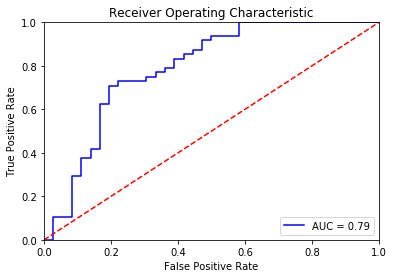

              precision    recall  f1-score   support

          NO       0.58      0.64      0.61        33
         YES       0.75      0.71      0.73        51

   micro avg       0.68      0.68      0.68        84
   macro avg       0.67      0.67      0.67        84
weighted avg       0.68      0.68      0.68        84

numer of total test sample:  84
Model Score:  [0.5886569761094593, 0.6785714228947958]
accuracy:  0.6785714285714286
missclassafication_rate:  0.3214285714285714
Sensitivity/Recall:  0.75
Spacificity:  0.5833333333333334
Precition:  0.7058823529411765
prevalence:  0.5714285714285714
Positive Predicted Value:  0.7058823529411765
Negative Predicted Value:  0.6363636363636364
F Score:  0.7272727272727273
fold #5
83/83 [==============================] - 0s 45us/step

Fold 5 score : [0.5455153182328466, 0.7590361460145697]
 Score: 0.7590361460145697
[[19 11]
 [ 9 44]]


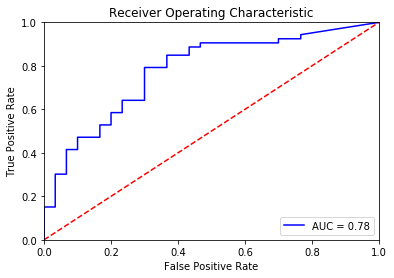

              precision    recall  f1-score   support

          NO       0.63      0.68      0.66        28
         YES       0.83      0.80      0.81        55

   micro avg       0.76      0.76      0.76        83
   macro avg       0.73      0.74      0.73        83
weighted avg       0.76      0.76      0.76        83

numer of total test sample:  83
Model Score:  [0.5455153182328466, 0.7590361460145697]
accuracy:  0.7590361445783133
missclassafication_rate:  0.24096385542168675
Sensitivity/Recall:  0.8301886792452831
Spacificity:  0.6333333333333333
Precition:  0.8
prevalence:  0.6385542168674698
Positive Predicted Value:  0.8
Negative Predicted Value:  0.6785714285714286
F Score:  0.8148148148148148
fold #6
83/83 [==============================] - 0s 47us/step

Fold 6 score : [0.6123241581112505, 0.6746987894356969]
 Score: 0.7590361460145697
[[21 14]
 [13 35]]


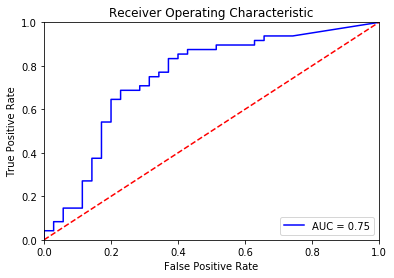

              precision    recall  f1-score   support

          NO       0.60      0.62      0.61        34
         YES       0.73      0.71      0.72        49

   micro avg       0.67      0.67      0.67        83
   macro avg       0.66      0.67      0.67        83
weighted avg       0.68      0.67      0.68        83

numer of total test sample:  83
Model Score:  [0.6123241581112505, 0.6746987894356969]
accuracy:  0.6746987951807228
missclassafication_rate:  0.32530120481927716
Sensitivity/Recall:  0.7291666666666666
Spacificity:  0.6
Precition:  0.7142857142857143
prevalence:  0.5783132530120482
Positive Predicted Value:  0.7142857142857143
Negative Predicted Value:  0.6176470588235294
F Score:  0.7216494845360825
fold #7
83/83 [==============================] - 0s 54us/step

Fold 7 score : [0.5563565585986677, 0.7590361388332872]
 Score: 0.7590361460145697
[[20 12]
 [ 8 43]]


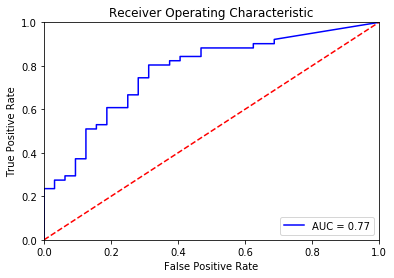

              precision    recall  f1-score   support

          NO       0.62      0.71      0.67        28
         YES       0.84      0.78      0.81        55

   micro avg       0.76      0.76      0.76        83
   macro avg       0.73      0.75      0.74        83
weighted avg       0.77      0.76      0.76        83

numer of total test sample:  83
Model Score:  [0.5563565585986677, 0.7590361388332872]
accuracy:  0.7590361445783133
missclassafication_rate:  0.24096385542168675
Sensitivity/Recall:  0.8431372549019608
Spacificity:  0.625
Precition:  0.7818181818181819
prevalence:  0.6144578313253012
Positive Predicted Value:  0.7818181818181819
Negative Predicted Value:  0.7142857142857143
F Score:  0.8113207547169812
fold #8
83/83 [==============================] - 0s 52us/step

Fold 8 score : [0.6331560274204576, 0.650602408920426]
 Score: 0.7590361460145697
[[18 21]
 [ 8 36]]


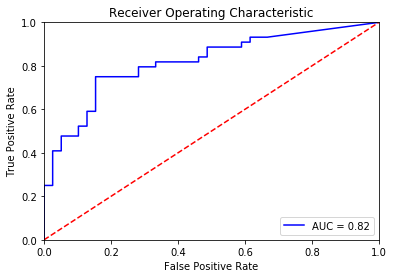

              precision    recall  f1-score   support

          NO       0.46      0.69      0.55        26
         YES       0.82      0.63      0.71        57

   micro avg       0.65      0.65      0.65        83
   macro avg       0.64      0.66      0.63        83
weighted avg       0.71      0.65      0.66        83

numer of total test sample:  83
Model Score:  [0.6331560274204576, 0.650602408920426]
accuracy:  0.6506024096385542
missclassafication_rate:  0.3493975903614458
Sensitivity/Recall:  0.8181818181818182
Spacificity:  0.46153846153846156
Precition:  0.631578947368421
prevalence:  0.5301204819277109
Positive Predicted Value:  0.631578947368421
Negative Predicted Value:  0.6923076923076923
F Score:  0.712871287128713
fold #9
83/83 [==============================] - 0s 66us/step

Fold 9 score : [0.6068699331168669, 0.7108433763664889]
 Score: 0.7590361460145697
[[24 12]
 [12 35]]


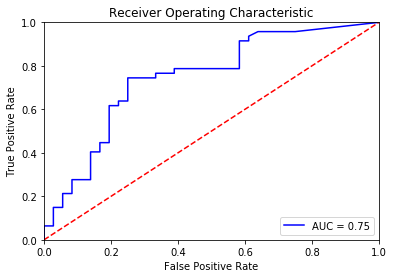

              precision    recall  f1-score   support

          NO       0.67      0.67      0.67        36
         YES       0.74      0.74      0.74        47

   micro avg       0.71      0.71      0.71        83
   macro avg       0.71      0.71      0.71        83
weighted avg       0.71      0.71      0.71        83

numer of total test sample:  83
Model Score:  [0.6068699331168669, 0.7108433763664889]
accuracy:  0.7108433734939759
missclassafication_rate:  0.28915662650602414
Sensitivity/Recall:  0.7446808510638298
Spacificity:  0.6666666666666666
Precition:  0.7446808510638298
prevalence:  0.5662650602409639
Positive Predicted Value:  0.7446808510638298
Negative Predicted Value:  0.6666666666666666
F Score:  0.7446808510638298
fold #10
83/83 [==============================] - 0s 59us/step

Fold 10 score : [0.6724696755409241, 0.6626506052821516]
 Score: 0.7590361460145697
[[12 17]
 [11 43]]


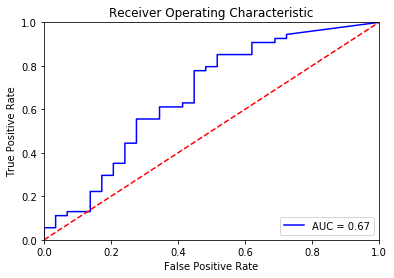

              precision    recall  f1-score   support

          NO       0.41      0.52      0.46        23
         YES       0.80      0.72      0.75        60

   micro avg       0.66      0.66      0.66        83
   macro avg       0.61      0.62      0.61        83
weighted avg       0.69      0.66      0.67        83

numer of total test sample:  83
Model Score:  [0.6724696755409241, 0.6626506052821516]
accuracy:  0.6626506024096386
missclassafication_rate:  0.3373493975903614
Sensitivity/Recall:  0.7962962962962963
Spacificity:  0.41379310344827586
Precition:  0.7166666666666667
prevalence:  0.6506024096385542
Positive Predicted Value:  0.7166666666666667
Negative Predicted Value:  0.5217391304347826
F Score:  0.7543859649122806


In [43]:
#cross valodation
nnc = Neural_Network('data_834.tab')
nnc.shuffle_the_data()
nnc.cross_validation_model_training()

In [45]:
nnc.best_score

0.7590361460145697

In [46]:
nnc.kfold_validation_score_store

[[0.5265263773146129, 0.7261904761904762],
 [0.6177554300853184, 0.6904761904761905],
 [0.5748097584361122, 0.7261904790287926],
 [0.5886569761094593, 0.6785714228947958],
 [0.5455153182328466, 0.7590361460145697],
 [0.6123241581112505, 0.6746987894356969],
 [0.5563565585986677, 0.7590361388332872],
 [0.6331560274204576, 0.650602408920426],
 [0.6068699331168669, 0.7108433763664889],
 [0.6724696755409241, 0.6626506052821516]]

In [93]:
#nn.model.get_weights()

In [48]:
nnc.model.evaluate(nnc.test_x,nnc.test_y)

83/83 [==============================] - 0s 99us/step


[0.6135051638247019, 0.6987951785685068]

In [49]:
nn.model.evaluate(nn.actual_x,nn.actual_y)

AttributeError: 'Neural_Network' object has no attribute 'model'